In [9]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.linalg import cholesky, solve_triangular
import seaborn as sns
sns.set(font_scale=1.0)
sns.set_style("white")
sns.set_style("ticks")
palette = sns.color_palette('deep')
plt.style.use('dark_background')

In [10]:
def kernel(xa, xb, amp, ll):
    Xa, Xb = get_tiled(xa, xb)
    return amp**2 * np.exp(-0.5 * 1./ll**2 * (Xa - Xb)**2 )

def get_tiled(xa, xb):
    m, n = len(xa), len(xb)
    xa, xb = xa.reshape(m,1) , xb.reshape(n,1)
    Xa = np.tile(xa, (1, n))
    Xb = np.tile(xb.T, (m, 1))
    return Xa, Xb

def get_posterior(amp, ll, x, x_data, y_data):
    u = y_data.shape[0]
    mu_y = np.mean(y_data)
    y = (y_data - mu_y).reshape(u,1)
    
    Kxx = kernel(x_data, x_data, amp, ll)
    Kxpx = kernel(x, x_data, amp, ll)
    Kxpxp = kernel(x, x, amp, ll)
    
    # Inverse
    jitter = np.eye(u) * 1e-8
    L = cholesky(Kxx + jitter)
    S1 = solve_triangular(L.T, y, lower=True)
    S2 = solve_triangular(L.T, Kxpx.T, lower=True).T
    
    mu = S2 @ S1  + mu_y
    cov = Kxpxp - S2 @ S2.T
    return mu, cov

In [16]:
x_data = np.random.rand(10)*4 - 2.
y_data = np.cos(5*x_data) + x_data**2 + 2*x_data
X = np.linspace(-2, 2, 150)
random_samples = 50

### Posterior

/var/folders/34/0177579s72zfk8k1ytk34_9c0346k7/T/ipykernel_11484/413438073.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


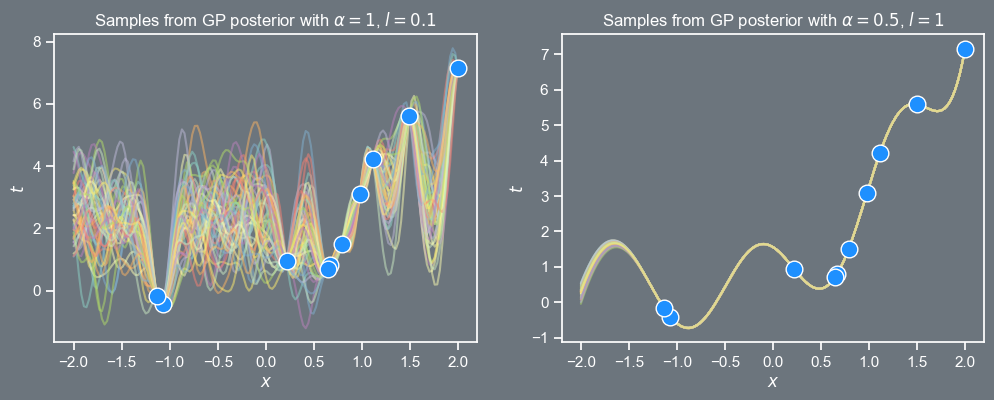

In [27]:
fig, ax = plt.subplots(2, figsize=(12,4))
fig.patch.set_facecolor('#6C757D')
ax[0].set_fc('#6C757D')
plt.subplot(121)
mu, cov = get_posterior(1, 0.1, X, x_data, y_data)
posterior = multivariate_normal(mu.flatten(), cov, allow_singular=True)
#mu = mu.flatten()
#std = np.sqrt(np.diag(cov)).flatten()
plt.plot(x_data, y_data, 'o', ms=12, color='dodgerblue', lw=1, markeredgecolor='w', zorder=3)
plt.plot(X, posterior.rvs(random_samples).T, alpha=0.5, zorder=2)
plt.title(r'Samples from GP posterior with $\alpha=1$, $l=0.1$')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
#plt.ylabel(r'$\mathbf{w}_1$')
fig.patch.set_facecolor('#6C757D')

plt.subplot(122)
plt.rcParams['axes.facecolor']='#6C757D'
ax[1].set_facecolor('#6C757D')
mu2, cov2 = get_posterior(0.5, 1, X, x_data, y_data)
posterior2 = multivariate_normal(mu2.flatten(), cov2, allow_singular=True)
plt.plot(x_data, y_data, 'o', ms=12, color='dodgerblue', lw=1, markeredgecolor='w', zorder=3)
plt.plot(X, posterior2.rvs(random_samples).T, alpha=0.5, zorder=2)
plt.title(r'Samples from GP posterior with $\alpha=0.5$, $l=1$')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.savefig('posterior.png', dpi=150, bbox_inches='tight', facecolor="#6C757D")
plt.show()

### Prior

/var/folders/34/0177579s72zfk8k1ytk34_9c0346k7/T/ipykernel_11484/1979853333.py:14: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


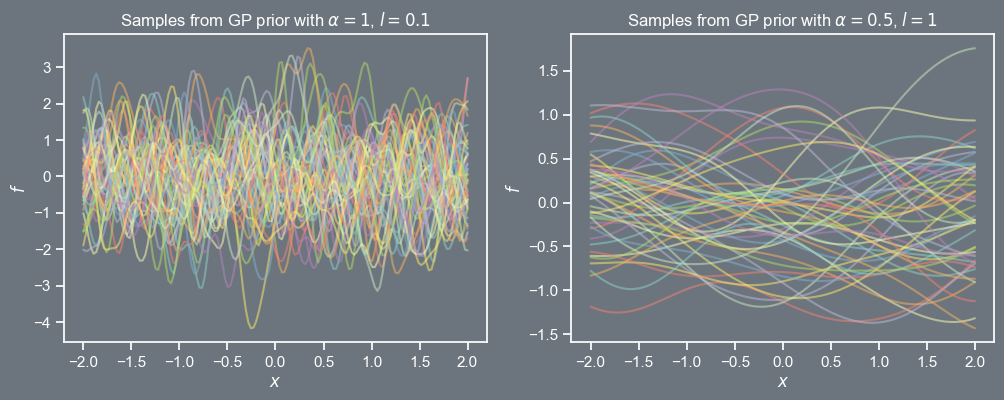

In [28]:
cov_1 = kernel(X, X, 1, 0.1) 
mu_1 = np.zeros((150,))
prior_1 = multivariate_normal(mu_1, cov_1, allow_singular=True)

cov_2 = kernel(X, X, 0.5, 1)
mu_2 = np.zeros((150,))
prior_2 = multivariate_normal(mu_2, cov_2, allow_singular=True)

random_samples = 50

fig, ax = plt.subplots(2, figsize=(12,4))
fig.patch.set_facecolor('#6C757D')
ax[0].set_fc('#6C757D')
plt.subplot(121)
plt.plot(X, prior_1.rvs(random_samples).T, alpha=0.5)
plt.title(r'Samples from GP prior with $\alpha=1$, $l=0.1$')
plt.xlabel(r'$x$')
plt.ylabel(r'$f$')
#plt.ylabel(r'$\mathbf{w}_1$')
fig.patch.set_facecolor('#6C757D')

plt.subplot(122)
plt.rcParams['axes.facecolor']='#6C757D'
ax[1].set_facecolor('#6C757D')
plt.plot(X, prior_2.rvs(random_samples).T, alpha=0.5)
plt.title(r'Samples from GP prior with $\alpha=0.5$, $l=1$')
plt.xlabel(r'$x$')
plt.ylabel(r'$f$')
plt.savefig('prior.png', dpi=150, bbox_inches='tight', facecolor="#6C757D")
plt.show()

### Priors from different kernels

/var/folders/34/0177579s72zfk8k1ytk34_9c0346k7/T/ipykernel_11484/3670138013.py:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


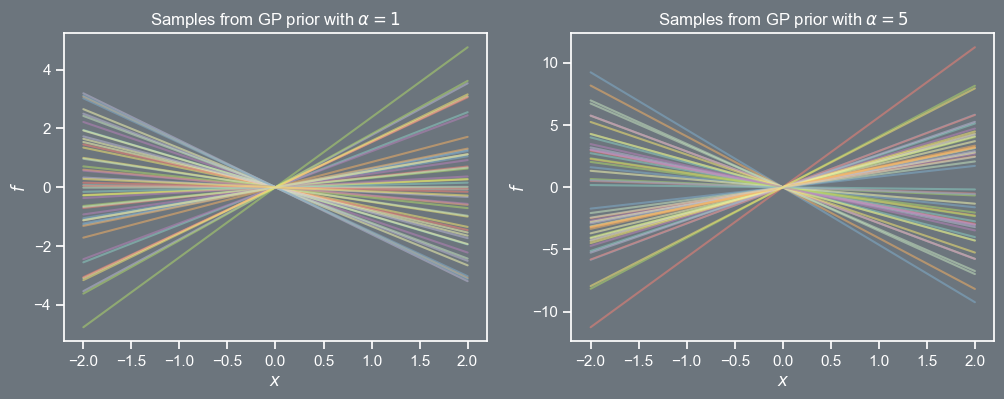

In [29]:
def linear_kernel(xa, xb, alpha):
    Xa, Xb = get_tiled(xa, xb)
    return alpha * np.multiply(Xa, Xb)

def get_tiled(xa, xb):
    m, n = len(xa), len(xb)
    xa, xb = xa.reshape(m,1) , xb.reshape(n,1)
    Xa = np.tile(xa, (1, n))
    Xb = np.tile(xb.T, (m, 1))
    return Xa, Xb

cov_1 = linear_kernel(X, X, 1) 
mu_1 = np.zeros((150,))
prior_1 = multivariate_normal(mu_1, cov_1, allow_singular=True)

cov_2 = linear_kernel(X, X, 5)
mu_2 = np.zeros((150,))
prior_2 = multivariate_normal(mu_2, cov_2, allow_singular=True)

random_samples = 50

fig, ax = plt.subplots(2, figsize=(12,4))
fig.patch.set_facecolor('#6C757D')
ax[0].set_fc('#6C757D')
plt.subplot(121)
plt.plot(X, prior_1.rvs(random_samples).T, alpha=0.5)
plt.title(r'Samples from GP prior with $\alpha=1$')
plt.xlabel(r'$x$')
plt.ylabel(r'$f$')
#plt.ylabel(r'$\mathbf{w}_1$')
fig.patch.set_facecolor('#6C757D')

plt.subplot(122)
plt.rcParams['axes.facecolor']='#6C757D'
ax[1].set_facecolor('#6C757D')
plt.plot(X, prior_2.rvs(random_samples).T, alpha=0.5)
plt.title(r'Samples from GP prior with $\alpha=5$')
plt.xlabel(r'$x$')
plt.ylabel(r'$f$')
plt.savefig('prior_linear.png', dpi=150, bbox_inches='tight', facecolor="#6C757D")
plt.show()

/var/folders/34/0177579s72zfk8k1ytk34_9c0346k7/T/ipykernel_11484/4272757535.py:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


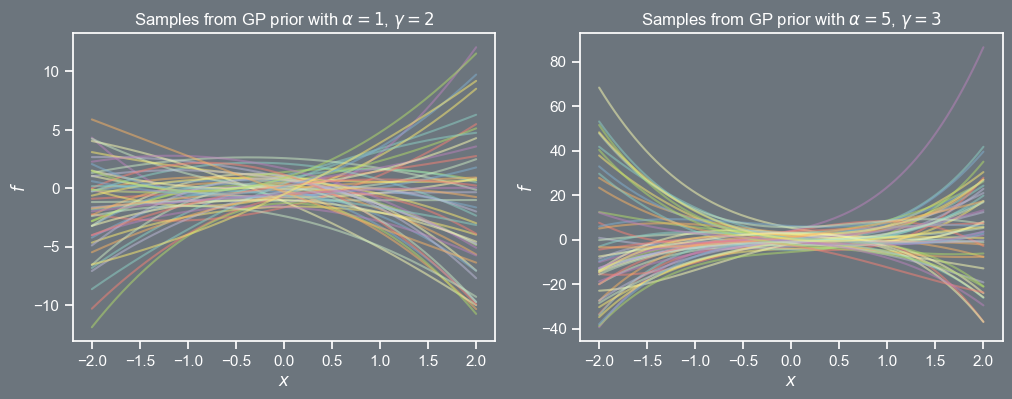

In [31]:
def poly_kernel(xa, xb, alpha, power):
    Xa, Xb = get_tiled(xa, xb)
    return alpha * (1 + np.multiply(Xa, Xb))**power 

def get_tiled(xa, xb):
    m, n = len(xa), len(xb)
    xa, xb = xa.reshape(m,1) , xb.reshape(n,1)
    Xa = np.tile(xa, (1, n))
    Xb = np.tile(xb.T, (m, 1))
    return Xa, Xb

cov_1 = poly_kernel(X, X, 1, 2) 
mu_1 = np.zeros((150,))
prior_1 = multivariate_normal(mu_1, cov_1, allow_singular=True)

cov_2 = poly_kernel(X, X, 5, 3)
mu_2 = np.zeros((150,))
prior_2 = multivariate_normal(mu_2, cov_2, allow_singular=True)

random_samples = 50

fig, ax = plt.subplots(2, figsize=(12,4))
fig.patch.set_facecolor('#6C757D')
ax[0].set_fc('#6C757D')
plt.subplot(121)
plt.plot(X, prior_1.rvs(random_samples).T, alpha=0.5)
plt.title(r'Samples from GP prior with $\alpha=1$, $\gamma=2$')
plt.xlabel(r'$x$')
plt.ylabel(r'$f$')
#plt.ylabel(r'$\mathbf{w}_1$')
fig.patch.set_facecolor('#6C757D')

plt.subplot(122)
plt.rcParams['axes.facecolor']='#6C757D'
ax[1].set_facecolor('#6C757D')
plt.plot(X, prior_2.rvs(random_samples).T, alpha=0.5)
plt.title(r'Samples from GP prior with $\alpha=5$, $\gamma=3$')
plt.xlabel(r'$x$')
plt.ylabel(r'$f$')
plt.savefig('prior_poly.png', dpi=150, bbox_inches='tight', facecolor="#6C757D")
plt.show()

/var/folders/34/0177579s72zfk8k1ytk34_9c0346k7/T/ipykernel_11484/4246620058.py:25: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


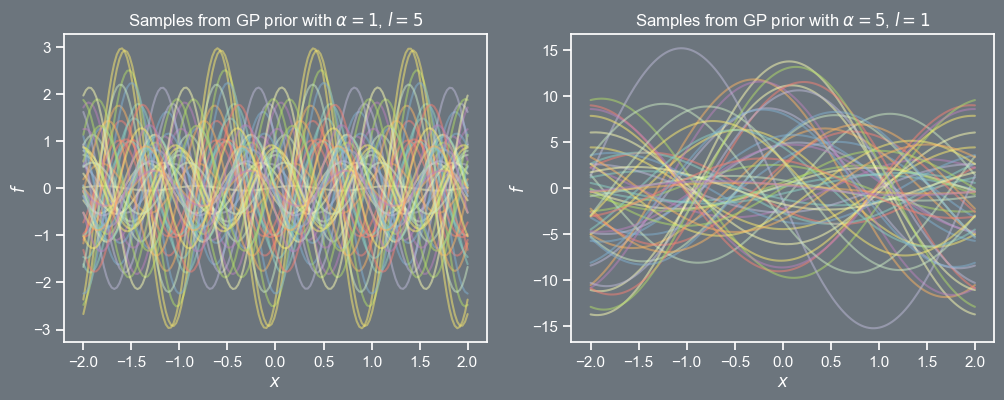

In [35]:
def cos_kernel(xa, xb, alpha, l):
    Xa, Xb = get_tiled(xa, xb)
    return alpha**2 * np.cos(2 * np.pi * (Xa - Xb)/l**2)

def get_tiled(xa, xb):
    m, n = len(xa), len(xb)
    xa, xb = xa.reshape(m,1) , xb.reshape(n,1)
    Xa = np.tile(xa, (1, n))
    Xb = np.tile(xb.T, (m, 1))
    return Xa, Xb

cov_1 = cos_kernel(X, X, 1, 1) 
mu_1 = np.zeros((150,))
prior_1 = multivariate_normal(mu_1, cov_1, allow_singular=True)

cov_2 = cos_kernel(X, X, 5, 2)
mu_2 = np.zeros((150,))
prior_2 = multivariate_normal(mu_2, cov_2, allow_singular=True)

random_samples = 50

fig, ax = plt.subplots(2, figsize=(12,4))
fig.patch.set_facecolor('#6C757D')
ax[0].set_fc('#6C757D')
plt.subplot(121)
plt.plot(X, prior_1.rvs(random_samples).T, alpha=0.5)
plt.title(r'Samples from GP prior with $\alpha=1$, $l=5$')
plt.xlabel(r'$x$')
plt.ylabel(r'$f$')
#plt.ylabel(r'$\mathbf{w}_1$')
fig.patch.set_facecolor('#6C757D')

plt.subplot(122)
plt.rcParams['axes.facecolor']='#6C757D'
ax[1].set_facecolor('#6C757D')
plt.plot(X, prior_2.rvs(random_samples).T, alpha=0.5)
plt.title(r'Samples from GP prior with $\alpha=5$, $l=1$')
plt.xlabel(r'$x$')
plt.ylabel(r'$f$')
plt.savefig('prior_cosine.png', dpi=150, bbox_inches='tight', facecolor="#6C757D")
plt.show()